# Laboratoire 2 : Arbre de désision, Bayes naïf et KNN
#### Département du génie logiciel et des technologies de l’information

| Étudiants             |                                                         |
|-----------------------|---------------------------------------------------------|
| Jean-Philippe Decoste |  DECJ19059105                                           |
| Ahmad Al-Taher        |   ALTA22109307                                          |
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2018                                            |
| Groupe                | 2                                                       |
| Numéro du laboratoire | 02                                                      |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 30 oct 2018                                             |

In [47]:
import math

import cv2 as cv
import graphviz
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face, imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn import preprocessing, tree
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, LeaveOneOut,StratifiedShuffleSplit,RepeatedKFold, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Email:    
    def __init__(self, features):
        self.features = features
        self.answer = int(self.features[len(self.features)-1]) == 1
        del self.features[-1]


In [3]:
class Image:    
    def __init__(self, features):
        self.features = features
        self.answer = self.features[len(self.features)-1] == 1
        del self.features[-1]
        self.id = int(self.features[0]) 
        del self.features[0]

In [73]:
def traceGraph(feature1x, feature1y, feature1Name, feature2x, feature2y, feature2Name, xlabel, ylabel, title):
    """
        This method is used to out a 2D graph with the selected features

        Args:
            feature1x : The feature 1 x array. It will be used for the first data set shown in the graph. 
            feature1y : The feature 1 y array. It will be used for the first data set shown in the graph.
            feature1Name : The feature 1 dataset name. It will be used for the first data set shown in the graph.
            feature2x : The feature 2 x array. It will be used for the first data set shown in the graph.
            feature2y : The feature 2yx array. It will be used for the first data set shown in the graph.
            feature2Name : The feature 2 dataset name. It will be used for the first data set shown in the graph.
            xlabel : the label shown on the x axis.
            ylabel: the label shown on the y axis:
     """
    #fig = plt.figure()
    #ax1 = fig.add_subplot()
    plt.grid(True)
    plt.scatter(feature1x, feature1y, s=10, c='b', marker="s", label=feature1Name)
    plt.scatter(feature2x, feature2y, s=10, c='r', marker="o", label=feature2Name)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.title(title)
    plt.show()

def loadEmailFeatures(emails, csvPath):
    """
        This method is used to al the email features from the data set.

        Args:
            csvPath: the dataset file path
    """
    csvFile = open(csvPath, 'r') # option r veut dire read
    #index is used to limit the numbero of data for test purposes
    index = 0
    for line in csvFile:
        features = line.split(",")
        if len(features) > 0:
            emails.append(Email(features))
        
        index +=1
        if index == 100:
            break

    csvFile.close()

def loadImageFeatures(images, csvPath):
    """
        This method is used to al the email features from the data set.

        Args:
            csvPath: the dataset file path
    """
    csvFile = open(csvPath, 'r') # option r veut dire read
    #index is used to limit the numbero of data for test purposes
    index = 0
    for line in csvFile:
        features = line.split(",")
        if len(features) > 0:            
            cleanCsvFeatures(features)
            images.append(Image(features))
        index +=1
        if index == 100:
            break

    csvFile.close()

def cleanCsvFeatures(features):
    """
        This method is used to transforme csv data into float number in order to work with them fluently.

        Args:
            features: the features to clean
    """
    #clean up the features
    #the csv files how the data as x.xxxxe+XX and we want tem as x.xxx
    for i,val in enumerate(features):
        features[i] = float(val)

        
def knnModel(dataset):
    """
        This method is used to apply the KNN method into the dataset.
        It uses K=3,5 and 10 and output the result of all.
        for each K it work with the uniform and the distance. Both are outputed.
        It uses gridsearchCV to acomplish that.
        StratifiedKfold is the method of validation.
        It uses 3 scoring methods (accuracy,precision,f1)
        it also produce a graph with the collected values.
        It output the best result based on the accuracy.

        Args:
            dataset: the dataset to work with
    """
    x=[]
    y=[]
    
    for data in dataset:
        x.append(data.features)
        y.append(data.answer)
    
    x =np.array(x).astype(np.float64)
    y =np.array(y).astype(np.float64)
    
    params = dict(n_neighbors=[3,5,10],weights=['uniform','distance'], algorithm=['auto'])
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5, iid=True,scoring={'accuracy','precision','f1'}, refit='accuracy')
    grid.fit(x, y)
    #print raw 
    #print(grid.cv_results_)
    #cv_results_['mean_test_score'] output is [uniform k=3,distance k=3,uniform k=10,distance k=10,uniform k=10,distance k=10]
    for i in range(0, 6):
        print("KNN %s with k=%s: score: %0.2f , precision: %0.2f , f1:%0.2f " %(grid.cv_results_['params'][i]['weights'],grid.cv_results_['params'][i]['n_neighbors'],grid.cv_results_['mean_test_accuracy'][i],grid.cv_results_['mean_test_precision'][i],grid.cv_results_['mean_test_f1'][i]))
    #print("KNN 'distance' has a score of %0.2f with k=%s" %(grid.cv_results_['mean_test_score'][1],k) )
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    a=[grid.cv_results_['mean_test_accuracy'][0],grid.cv_results_['mean_test_accuracy'][2],grid.cv_results_['mean_test_accuracy'][4]]
    b=[grid.cv_results_['mean_test_accuracy'][1],grid.cv_results_['mean_test_accuracy'][3],grid.cv_results_['mean_test_accuracy'][5]]
    c=[3,5,10]
    d=[grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_precision'][2],grid.cv_results_['mean_test_precision'][4]]
    e=[grid.cv_results_['mean_test_precision'][1],grid.cv_results_['mean_test_precision'][3],grid.cv_results_['mean_test_precision'][5]]
    f=[grid.cv_results_['mean_test_f1'][0],grid.cv_results_['mean_test_f1'][2],grid.cv_results_['mean_test_f1'][4]]
    g=[grid.cv_results_['mean_test_f1'][1],grid.cv_results_['mean_test_f1'][3],grid.cv_results_['mean_test_f1'][5]]
    
    traceGraph(c,a,'uniform',c,b,'distance','k','accuracy', "accuracy/K")
    traceGraph(c,d,'uniform',c,e,'distance','k','precision',"precision/K")
    traceGraph(c,f,'uniform',c,g,'distance','k','f1',"f1/K")
    
def knnModelLOO(dataset):
    """
        This method is used to apply the KNN method into the dataset.
        It uses K=3,5 and 10 and output the result of all.
        for each K it work with the uniform and the distance. Both are outputed.
        It uses gridsearchCV to acomplish that.
        LeaveOneOUT is the method of validation.
        It uses 3 scoring methods (accuracy,precision,f1)
        it also produce a graph with the collected values.
        It output the best result based on the accuracy.

        Args:
            dataset: the dataset to work with
    """
    x=[]
    y=[]
    
    for data in dataset:
        x.append(data.features)
        y.append(data.answer)
    
    x =np.array(x).astype(np.float64)
    y =np.array(y).astype(np.float64)
    
    params = dict(n_neighbors=[3,5,10],weights=['uniform','distance'], algorithm=['auto'])
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=LeaveOneOut(), iid=True,scoring={'accuracy','precision','f1'}, refit='accuracy')
    grid.fit(x, y)
    #print raw 
    #print(grid.cv_results_)
    #cv_results_['mean_test_score'] output is [uniform k=3,distance k=3,uniform k=10,distance k=10,uniform k=10,distance k=10]
    for i in range(0, 6):
        print("KNN %s with k=%s: score: %0.2f , precision: %0.2f , f1:%0.2f " %(grid.cv_results_['params'][i]['weights'],grid.cv_results_['params'][i]['n_neighbors'],grid.cv_results_['mean_test_accuracy'][i],grid.cv_results_['mean_test_precision'][i],grid.cv_results_['mean_test_f1'][i]))
    #print("KNN 'distance' has a score of %0.2f with k=%s" %(grid.cv_results_['mean_test_score'][1],k) )
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    a=[grid.cv_results_['mean_test_accuracy'][0],grid.cv_results_['mean_test_accuracy'][2],grid.cv_results_['mean_test_accuracy'][4]]
    b=[grid.cv_results_['mean_test_accuracy'][1],grid.cv_results_['mean_test_accuracy'][3],grid.cv_results_['mean_test_accuracy'][5]]
    c=[3,5,10]
    d=[grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_precision'][2],grid.cv_results_['mean_test_precision'][4]]
    e=[grid.cv_results_['mean_test_precision'][1],grid.cv_results_['mean_test_precision'][3],grid.cv_results_['mean_test_precision'][5]]
    f=[grid.cv_results_['mean_test_f1'][0],grid.cv_results_['mean_test_f1'][2],grid.cv_results_['mean_test_f1'][4]]
    g=[grid.cv_results_['mean_test_f1'][1],grid.cv_results_['mean_test_f1'][3],grid.cv_results_['mean_test_f1'][5]]
    
    traceGraph(c,a,'uniform',c,b,'distance','k','accuracy', "LOO:accuracy/K")
    traceGraph(c,d,'uniform',c,e,'distance','k','precision',"LOO:precision/K")
    traceGraph(c,f,'uniform',c,g,'distance','k','f1',"LOO:f1/K")
    
def knnModelSSS(dataset):
    """
        This method is used to apply the KNN method into the dataset.
        It uses K=3,5 and 10 and output the result of all.
        for each K it work with the uniform and the distance. Both are outputed.
        It uses gridsearchCV to acomplish that.
        StratifiedShuffleSplit is the method of validation.
        It uses 3 scoring methods (accuracy,precision,f1)
        it also produce a graph with the collected values.
        It output the best result based on the accuracy.

        Args:
            dataset: the dataset to work with
    """
    x=[]
    y=[]
    
    for data in dataset:
        x.append(data.features)
        y.append(data.answer)
    
    x =np.array(x).astype(np.float64)
    y =np.array(y).astype(np.float64)
    
    params = dict(n_neighbors=[3,5,10],weights=['uniform','distance'], algorithm=['auto'])
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=StratifiedShuffleSplit(), iid=True,scoring={'accuracy','precision','f1'}, refit='accuracy')
    grid.fit(x, y)
    #print raw 
    #print(grid.cv_results_)
    #cv_results_['mean_test_score'] output is [uniform k=3,distance k=3,uniform k=10,distance k=10,uniform k=10,distance k=10]
    for i in range(0, 6):
        print("KNN %s with k=%s: score: %0.2f , precision: %0.2f , f1:%0.2f " %(grid.cv_results_['params'][i]['weights'],grid.cv_results_['params'][i]['n_neighbors'],grid.cv_results_['mean_test_accuracy'][i],grid.cv_results_['mean_test_precision'][i],grid.cv_results_['mean_test_f1'][i]))
    #print("KNN 'distance' has a score of %0.2f with k=%s" %(grid.cv_results_['mean_test_score'][1],k) )
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    a=[grid.cv_results_['mean_test_accuracy'][0],grid.cv_results_['mean_test_accuracy'][2],grid.cv_results_['mean_test_accuracy'][4]]
    b=[grid.cv_results_['mean_test_accuracy'][1],grid.cv_results_['mean_test_accuracy'][3],grid.cv_results_['mean_test_accuracy'][5]]
    c=[3,5,10]
    d=[grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_precision'][2],grid.cv_results_['mean_test_precision'][4]]
    e=[grid.cv_results_['mean_test_precision'][1],grid.cv_results_['mean_test_precision'][3],grid.cv_results_['mean_test_precision'][5]]
    f=[grid.cv_results_['mean_test_f1'][0],grid.cv_results_['mean_test_f1'][2],grid.cv_results_['mean_test_f1'][4]]
    g=[grid.cv_results_['mean_test_f1'][1],grid.cv_results_['mean_test_f1'][3],grid.cv_results_['mean_test_f1'][5]]
    
    traceGraph(c,a,'uniform',c,b,'distance','k','accuracy', "SSS:accuracy/K")
    traceGraph(c,d,'uniform',c,e,'distance','k','precision',"SSS:precision/K")
    traceGraph(c,f,'uniform',c,g,'distance','k','f1',"SSS:f1/K")
    
def bayes(dataset):
    """
        This method is used to apply the bayes twices. 
        Bayes is produced with MultinomialNB. 
        It uses gridsearchCV to acomplish that.
        First run, it uses normalized data.
        second run, it uses discretized data with KBinsDiscretizer with k=3 
        StratifiedKFold is the method of validation.

        Args:
            dataset: the dataset to work with
    """
    x=[]
    y=[]
    
    for data in dataset:
        x.append(data.features)
        y.append(data.answer)
    
    x =np.array(x).astype(np.float64)
    y =np.array(y).astype(np.float64)
    
    scaler = MinMaxScaler()
    scaler.fit(x)
    xNormalized = scaler.transform(x) 
    grid = GridSearchCV(MultinomialNB(), param_grid={}, cv=5, iid=True,scoring={'accuracy','precision','f1'}, refit='accuracy')
    grid.fit(xNormalized, y)
    
    #print raw 
    #print(grid.cv_results_)
    
    print("MultinomialNB with normalized values best score is %0.2f. Precision: %0.2f , f1: %0.2f" % ( grid.best_score_,grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_f1'][0]))
    
    est = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    
    est.fit(x)
    xKBinsDiscretizer = est.transform(x)
    
    grid.fit(xKBinsDiscretizer, y)
    
    #print raw 
    #print(grid.cv_results_)
    
    print("MultinomialNB with discretized values best score is %0.2f. Precision: %0.2f , f1: %0.2f" % ( grid.best_score_,grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_f1'][0]))
  
def bayesLOO(dataset):
    """
        This method is used to apply the bayes twices. 
        Bayes is produced with MultinomialNB. 
        It uses gridsearchCV to acomplish that.
        First run, it uses normalized data.
        second run, it uses discretized data with KBinsDiscretizer with k=3 
        LeaveOneOut is the method of validation.

        Args:
            dataset: the dataset to work with
    """
    x=[]
    y=[]
    
    for data in dataset:
        x.append(data.features)
        y.append(data.answer)
    
    x =np.array(x).astype(np.float64)
    y =np.array(y).astype(np.float64)
    
    scaler = MinMaxScaler()
    scaler.fit(x)
    xNormalized = scaler.transform(x) 
    grid = GridSearchCV(MultinomialNB(), param_grid={}, cv=LeaveOneOut(), iid=True,scoring={'accuracy','precision','f1'}, refit='accuracy')
    grid.fit(xNormalized, y)
    
    #print raw 
    #print(grid.cv_results_)
    
    print("MultinomialNB with normalized values best score is %0.2f. Precision: %0.2f , f1: %0.2f" % ( grid.best_score_,grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_f1'][0]))
    
    est = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    
    est.fit(x)
    xKBinsDiscretizer = est.transform(x)
    
    grid.fit(xKBinsDiscretizer, y)
    
    #print raw 
    #print(grid.cv_results_)
    
    print("MultinomialNB with discretized values best score is %0.2f. Precision: %0.2f , f1: %0.2f" % ( grid.best_score_,grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_f1'][0]))
    
def bayesSSS(dataset):
    """
        This method is used to apply the bayes twices. 
        Bayes is produced with MultinomialNB. 
        It uses gridsearchCV to acomplish that.
        First run, it uses normalized data.
        second run, it uses discretized data with KBinsDiscretizer with k=3 
        StratifiedShuffleSplit is the method of validation.

        Args:
            dataset: the dataset to work with
    """
    x=[]
    y=[]
    
    for data in dataset:
        x.append(data.features)
        y.append(data.answer)
    
    x =np.array(x).astype(np.float64)
    y =np.array(y).astype(np.float64)
    
    scaler = MinMaxScaler()
    scaler.fit(x)
    xNormalized = scaler.transform(x) 
    grid = GridSearchCV(MultinomialNB(), param_grid={}, cv=StratifiedShuffleSplit(), iid=True,scoring={'accuracy','precision','f1'}, refit='accuracy')
    grid.fit(xNormalized, y)
    
    #print raw 
    #print(grid.cv_results_)
    
    print("MultinomialNB with normalized values best score is %0.2f. Precision: %0.2f , f1: %0.2f" % ( grid.best_score_,grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_f1'][0]))
    
    est = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    
    est.fit(x)
    xKBinsDiscretizer = est.transform(x)
    
    grid.fit(xKBinsDiscretizer, y)
    
    #print raw 
    #print(grid.cv_results_)
    
    print("MultinomialNB with discretized values best score is %0.2f. Precision: %0.2f , f1: %0.2f" % ( grid.best_score_,grid.cv_results_['mean_test_precision'][0],grid.cv_results_['mean_test_f1'][0]))
    

Working with the emails
StratifiedKfold
KNN uniform with k=3: score: 0.68 , precision: 0.41 , f1:0.29 
KNN distance with k=3: score: 0.69 , precision: 0.41 , f1:0.35 
KNN uniform with k=5: score: 0.64 , precision: 0.34 , f1:0.22 
KNN distance with k=5: score: 0.65 , precision: 0.38 , f1:0.21 
KNN uniform with k=10: score: 0.69 , precision: 0.06 , f1:0.05 
KNN distance with k=10: score: 0.67 , precision: 0.21 , f1:0.17 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} with a score of 0.69


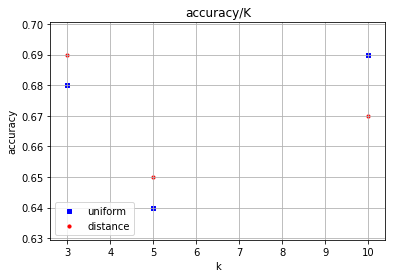

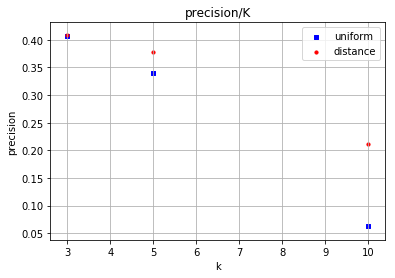

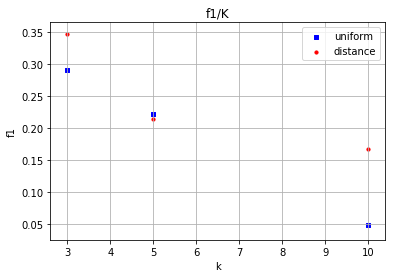

Leave One Out
KNN uniform with k=3: score: 0.71 , precision: 0.09 , f1:0.09 
KNN distance with k=3: score: 0.71 , precision: 0.11 , f1:0.11 
KNN uniform with k=5: score: 0.67 , precision: 0.06 , f1:0.06 
KNN distance with k=5: score: 0.68 , precision: 0.06 , f1:0.06 
KNN uniform with k=10: score: 0.69 , precision: 0.02 , f1:0.02 
KNN distance with k=10: score: 0.67 , precision: 0.03 , f1:0.03 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} with a score of 0.71


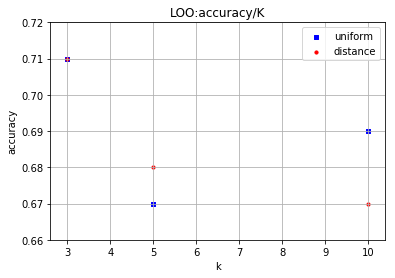

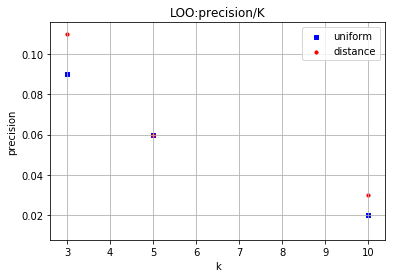

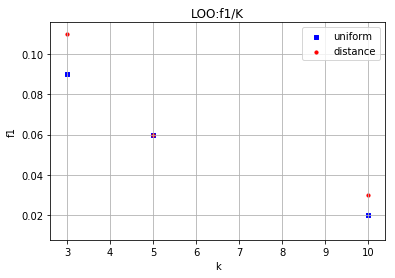

StratifiedShuffleSplit
KNN uniform with k=3: score: 0.75 , precision: 0.68 , f1:0.45 
KNN distance with k=3: score: 0.74 , precision: 0.58 , f1:0.48 
KNN uniform with k=5: score: 0.67 , precision: 0.27 , f1:0.20 
KNN distance with k=5: score: 0.72 , precision: 0.58 , f1:0.37 
KNN uniform with k=10: score: 0.67 , precision: 0.10 , f1:0.05 
KNN distance with k=10: score: 0.70 , precision: 0.40 , f1:0.20 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} with a score of 0.75


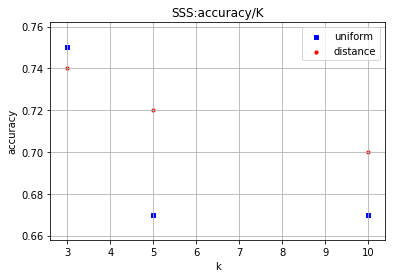

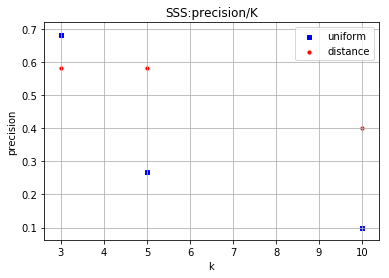

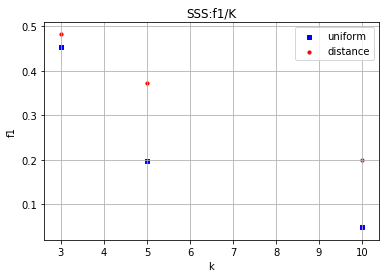

StratifiedKfold
MultinomialNB with normalized values best score is 0.89. Precision: 0.94 , f1: 0.74
MultinomialNB with discretized values best score is 0.77. Precision: 0.65 , f1: 0.61
Leave One Out
MultinomialNB with normalized values best score is 0.92. Precision: 0.20 , f1: 0.20
MultinomialNB with discretized values best score is 0.77. Precision: 0.18 , f1: 0.18
StratifiedShuffleSplit
MultinomialNB with normalized values best score is 0.92. Precision: 1.00 , f1: 0.83
MultinomialNB with discretized values best score is 0.83. Precision: 0.67 , f1: 0.65
Working with the images
KNN uniform with k=3: score: 0.61 , precision: 0.58 , f1:0.57 
KNN distance with k=3: score: 0.59 , precision: 0.57 , f1:0.55 
KNN uniform with k=5: score: 0.62 , precision: 0.59 , f1:0.57 
KNN distance with k=5: score: 0.60 , precision: 0.57 , f1:0.55 
KNN uniform with k=10: score: 0.62 , precision: 0.64 , f1:0.51 
KNN distance with k=10: score: 0.63 , precision: 0.61 , f1:0.59 
The best parameters are {'algorit

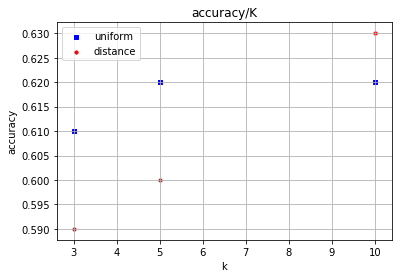

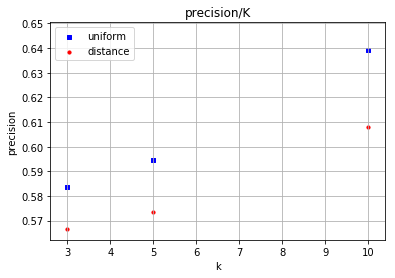

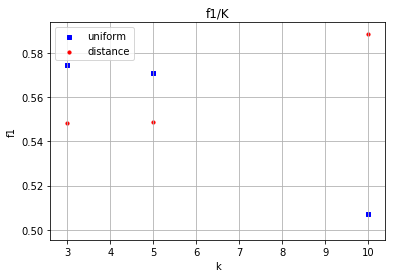

StratifiedKfold
KNN uniform with k=3: score: 0.61 , precision: 0.58 , f1:0.57 
KNN distance with k=3: score: 0.59 , precision: 0.57 , f1:0.55 
KNN uniform with k=5: score: 0.62 , precision: 0.59 , f1:0.57 
KNN distance with k=5: score: 0.60 , precision: 0.57 , f1:0.55 
KNN uniform with k=10: score: 0.62 , precision: 0.64 , f1:0.51 
KNN distance with k=10: score: 0.63 , precision: 0.61 , f1:0.59 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'} with a score of 0.63


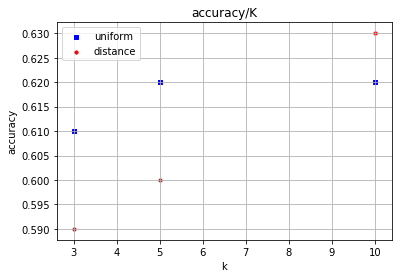

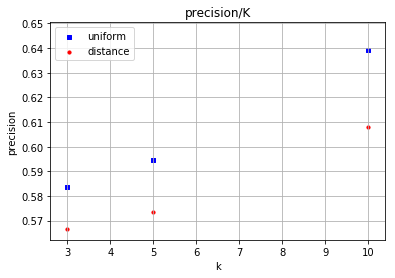

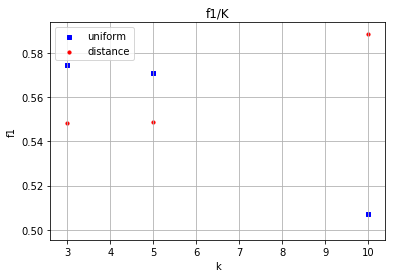

Leave One Out
KNN uniform with k=3: score: 0.54 , precision: 0.23 , f1:0.23 
KNN distance with k=3: score: 0.55 , precision: 0.25 , f1:0.25 
KNN uniform with k=5: score: 0.61 , precision: 0.27 , f1:0.27 
KNN distance with k=5: score: 0.58 , precision: 0.25 , f1:0.25 
KNN uniform with k=10: score: 0.60 , precision: 0.19 , f1:0.19 
KNN distance with k=10: score: 0.56 , precision: 0.24 , f1:0.24 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'} with a score of 0.61


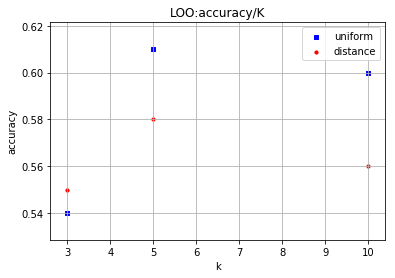

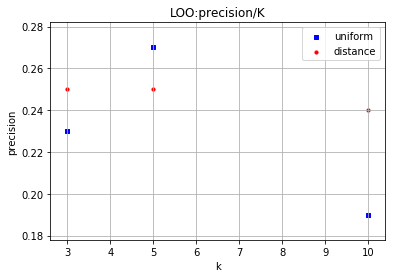

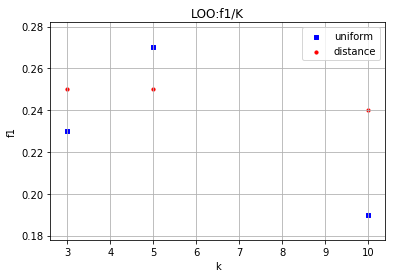

StratifiedShuffleSplit
KNN uniform with k=3: score: 0.55 , precision: 0.56 , f1:0.52 
KNN distance with k=3: score: 0.56 , precision: 0.57 , f1:0.53 
KNN uniform with k=5: score: 0.61 , precision: 0.65 , f1:0.59 
KNN distance with k=5: score: 0.57 , precision: 0.58 , f1:0.53 
KNN uniform with k=10: score: 0.61 , precision: 0.66 , f1:0.54 
KNN distance with k=10: score: 0.59 , precision: 0.60 , f1:0.55 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'} with a score of 0.61


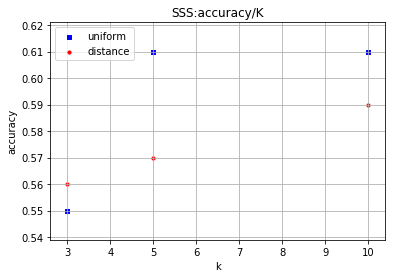

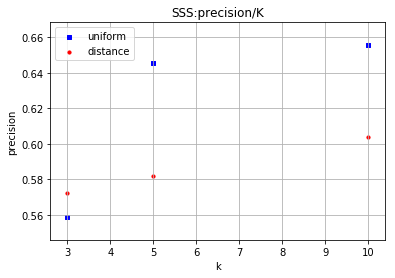

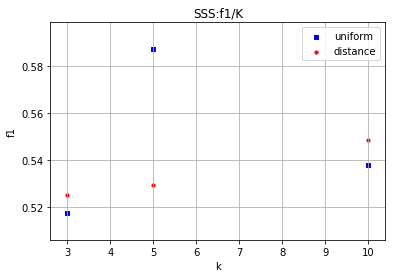

StratifiedKfold
MultinomialNB with normalized values best score is 0.71. Precision: 0.83 , f1: 0.60
MultinomialNB with discretized values best score is 0.71. Precision: 0.71 , f1: 0.62
Leave One Out
MultinomialNB with normalized values best score is 0.72. Precision: 0.23 , f1: 0.23
MultinomialNB with discretized values best score is 0.71. Precision: 0.29 , f1: 0.29
StratifiedShuffleSplit
MultinomialNB with normalized values best score is 0.69. Precision: 0.86 , f1: 0.58
MultinomialNB with discretized values best score is 0.71. Precision: 0.77 , f1: 0.68


In [76]:
Emails = []
Images = []

loadEmailFeatures(Emails, r"C:\Users\ThinkPad\Downloads\gti770\data\csv\spam\spam.csv")
loadImageFeatures(Images, r"C:\Users\ThinkPad\Downloads\gti770\data\csv\galaxy\galaxy_feature_vectors.csv")
#knn 
print("Working with the emails")
print("StratifiedKfold")
knnModel(Emails)
print("Leave One Out")
knnModelLOO(Emails)
print("StratifiedShuffleSplit")
knnModelSSS(Emails)
print("StratifiedKfold")
bayes(Emails)
print("Leave One Out")
bayesLOO(Emails)
print("StratifiedShuffleSplit")
bayesSSS(Emails)

print("Working with the images")
knnModel(Images)
print("StratifiedKfold")
knnModel(Images)
print("Leave One Out")
knnModelLOO(Images)
print("StratifiedShuffleSplit")
knnModelSSS(Images)
print("StratifiedKfold")
bayes(Images)
print("Leave One Out")
bayesLOO(Images)
print("StratifiedShuffleSplit")
bayesSSS(Images)


## Introduction

In [45]:
*to delete
résultat des algo sans rajouté de nos premitive
KNN uniform has a score of 0.68 with k=3 
KNN distance has a score of 0.69 with k=3 
KNN uniform has a score of 0.64 with k=5 
KNN distance has a score of 0.65 with k=5 
KNN uniform has a score of 0.69 with k=10 
KNN distance has a score of 0.67 with k=10 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} with a score of 0.69
MultinomialNB with normalized values best score is 0.89
MultinomialNB with discretized values best score is 0.77
Working with the images
KNN uniform has a score of 0.61 with k=3 
KNN distance has a score of 0.59 with k=3 
KNN uniform has a score of 0.62 with k=5 
KNN distance has a score of 0.60 with k=5 
KNN uniform has a score of 0.62 with k=10 
KNN distance has a score of 0.63 with k=10 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'} with a score of 0.63
MultinomialNB with normalized values best score is 0.71
MultinomialNB with discretized values best score is 0.71

SyntaxError: invalid syntax (<ipython-input-45-30f04d5a1ceb>, line 1)

## Question 1
### Méthode de création des ensembles de données

## Question 1
### Détails des ensembles produits

## Question 2
### Approche de validation proposée et justification

## Question 3
### Matrice des expérimentations

## Question 3
### Étude des hyperparamètres et des modèles

## Question 4
### Impact de la taille des ensembles de données sur la performance de classification

## Question 5
### Impact du bruit dans les ensembles de données sur la performance de classification

## Question 6
### Discussion sur la nature des données

## Question 7
### Recommandations

## Question 8
### Améliorations possibles

## Conclusion

## Bibliographie